# Dispersion: A Full Two Fluid Solution

[tfds]: ../../api/plasmapy.dispersion.analytical.two_fluid_.two_fluid.rst
[bellan2012]: https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2012JA017856
[stringer1963]: https://doi.org/10.1088/0368-3281/5/2/304

This notebook walks through the functionality of the [two_fluid()][tfds] function.  This function computes the wave frequencies for given wavenumbers and plasma parameters based on the analytical solution presented by [Bellan 2012][bellan2012] to the [Stringer 1963][stringer1963] two fluid dispersion relation.  The two fluid dispersion equaiton assumes a uniform magnetic field, a zero D.C. electric field, and low-frequency waves $\omega / k c \ll 1$ which equates to

$$
    \left( \cos^2 \theta - Q \frac{\omega^2}{k^2 {v_A}^2} \right)
    \left[
        \left( \cos^2 \theta - \frac{\omega^2}{k^2 {c_s}^2} \right)
        - Q \frac{\omega^2}{k^2 {v_A}^2} \left(
            1 - \frac{\omega^2}{k^2 {c_s}^2}
        \right)
    \right] \\
    = \left(1 - \frac{\omega^2}{k^2 {c_s}^2} \right)
      \frac{\omega^2}{{\omega_{ci}}^2} \cos^2 \theta
$$

where

$$Q = 1 + k^2 c^2/{\omega_{pe}}^2$$

$$\cos \theta = \frac{k_z}{k}$$

$$\mathbf{B_o} = B_{o} \mathbf{\hat{z}}$$

$\omega$ is the wave frequency, $k$ is the wavenumber, $v_A$ is the Alfvén velocity, $c_s$ is the sound speed, $\omega_{ci}$ is the ion gyrofrequency, and $\omega_{pe}$ is the electron plasma frequency.

The approach outlined in Section 5 of [Bellan 2012][bellan2012] produces exact roots to the above dispersion equation for all three modes (fast, acoustic, and Alfvén) without having to make additional approximations.  The following dispersion relation is what the [two_fluid()][tfds] function computes.

$$
    \frac{\omega}{\omega_{ci}} = \sqrt{
        2 \Lambda \sqrt{-\frac{P}{3}} \cos\left(
            \frac{1}{3} \cos^{-1}\left(
                \frac{3q}{2p} \sqrt{-\frac{3}{p}}
            \right)
            - \frac{2 \pi}{3}j
        \right)
        + \frac{\Lambda A}{3}
    }
$$

where $j = 0$ represents the fast mode, $j = 1$ represents the Alfvén mode, and $j = 2$ represents the acoustic mode.  Additionally,

$$p = \frac{3B-A^2}{3} \; , \; q = \frac{9AB-2A^3-27C}{27}$$

$$A = \frac{Q + Q^2 \beta + Q \alpha + \alpha \Lambda}{Q^2} \;
    , \; B = \alpha \frac{1 + 2 Q \beta + \Lambda \beta}{Q^2} \;
    , \; C = \frac{\alpha^2 \beta}{Q^2}$$

$$\alpha = \cos^2 \theta \;
    , \; \beta = \left( \frac{c_s}{v_A}\right)^2 \;
    , \; \Lambda = \left( \frac{k v_{A}}{\omega_{ci}}\right)^2$$

## Contents:

1. [Wave Propagating at 45 Degrees](#Wave-Propagating-at-45-Degrees)
2. [Wave frequencies on the k-theta plane](#Wave-frequencies-on-the-k-theta-plane)
3. [Reproduce Figure 1 from Bellan 2012](#Reproduce-Figure-1-from-Bellan-2012)

In [1]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.constants.si import c
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

from plasmapy.dispersion.analytical.two_fluid_ import two_fluid
from plasmapy.formulary import speeds
from plasmapy.formulary.frequencies import gyrofrequency, plasma_frequency, wc_, wp_
from plasmapy.formulary.lengths import inertial_length
from plasmapy.particles import Particle

plt.rcParams["figure.figsize"] = [10.5, 0.56 * 10.5]

## Wave Propagating at 45 Degrees

Below we define the required parameters to compute the wave frequencies.

In [2]:
# define input parameters
inputs = {
    "k": np.linspace(10**-7, 10**-2, 10000) * u.rad / u.m,
    "theta": 45 * u.deg,
    "n_i": 5 * u.cm**-3,
    "B": 8.3e-9 * u.T,
    "T_e": 1.6e6 * u.K,
    "T_i": 4.0e5 * u.K,
    "ion": Particle("p+"),
}

# a few useful plasma parameters
params = {
    "n_e": inputs["n_i"] * abs(inputs["ion"].charge_number),
    "cs": speeds.ion_sound_speed(
        inputs["T_e"],
        inputs["T_i"],
        inputs["ion"],
    ),
    "va": speeds.Alfven_speed(
        inputs["B"],
        inputs["n_i"],
        ion=inputs["ion"],
    ),
    "wci": gyrofrequency(inputs["B"], inputs["ion"]),
}
params["lpe"] = inertial_length(params["n_e"], "e-")
params["wpe"] = plasma_frequency(params["n_e"], "e-")

The computed wave frequencies ($rad/s$) are returned in a dictionary with keys representing the wave modes and the values being an Astropy [Quantity](https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity).  Since our inputs had a scalar $\theta$ and a 1D array of $k$'s, the computed wave frequencies will be a 1D array of size equal to the size of the $k$ array.

In [3]:
# compute
omegas = two_fluid(**inputs)

(list(omegas.keys()), omegas["fast_mode"], omegas["fast_mode"].shape)

(['fast_mode', 'alfven_mode', 'acoustic_mode'],
 <Quantity [1.63839709e-02, 1.80262570e-01, 3.44262572e-01, ...,
            1.52032171e+03, 1.52047365e+03, 1.52062560e+03] rad / s>,
 (10000,))

Let's plot the results of each wave mode.

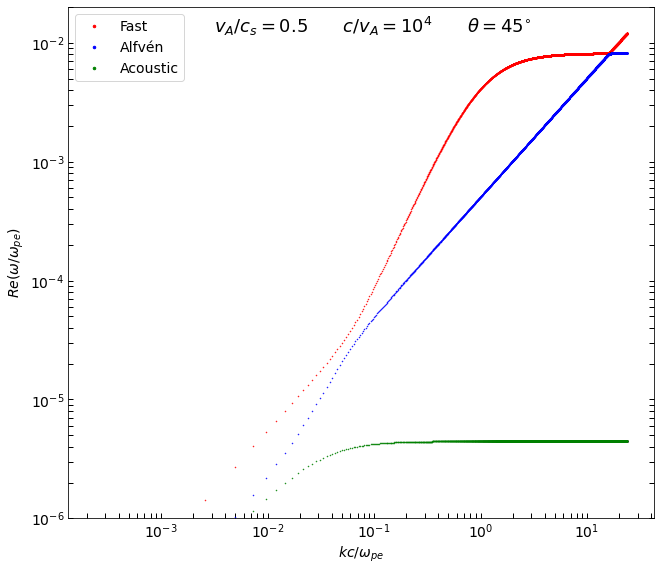

In [4]:
fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

# normalize data
k_prime = inputs["k"] * params["lpe"]

# plot
plt.plot(
    k_prime,
    np.real(omegas["fast_mode"] / params["wpe"]),
    "r.",
    ms=1,
    label="Fast",
)
ax = plt.gca()
ax.plot(
    k_prime,
    np.real(omegas["alfven_mode"] / params["wpe"]),
    "b.",
    ms=1,
    label="Alfvén",
)
ax.plot(
    k_prime,
    np.real(omegas["acoustic_mode"] / params["wpe"]),
    "g.",
    ms=1,
    label="Acoustic",
)

# adjust axes
ax.set_xlabel(r"$kc / \omega_{pe}$", fontsize=fs)
ax.set_ylabel(r"$Re(\omega / \omega_{pe})$", fontsize=fs)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(1e-6, 2e-2)
ax.tick_params(
    which="both",
    direction="in",
    width=1,
    labelsize=fs,
    right=True,
    length=5,
)

# annotate
text = (
    f"$v_A/c_s = {params['va'] / params['cs']:.1f} \qquad "
    f"c/v_A = 10^{np.log10(c / params['va']):.0f} \qquad "
    f"\\theta = {inputs['theta'].value:.0f}"
    "^{\\circ}$"
)
ax.text(0.25, 0.95, text, transform=ax.transAxes, fontsize=18)
ax.legend(loc="upper left", markerscale=5, fontsize=fs)

## Wave frequencies on the k-theta plane

Let us now look at the distribution of $\omega$ on a $k$-$\theta$ plane.

In [5]:
# define input parameters
inputs = {
    "k": np.linspace(10**-7, 10**-2, 10000) * u.rad / u.m,
    "theta": np.linspace(5, 85, 100) * u.deg,
    "n_i": 5 * u.cm**-3,
    "B": 8.3e-9 * u.T,
    "T_e": 1.6e6 * u.K,
    "T_i": 4.0e5 * u.K,
    "ion": Particle("p+"),
}

# a few useful plasma parameters
params = {
    "n_e": inputs["n_i"] * abs(inputs["ion"].charge_number),
    "cs": speeds.ion_sound_speed(
        inputs["T_e"],
        inputs["T_i"],
        inputs["ion"],
    ),
    "va": speeds.Alfven_speed(
        inputs["B"],
        inputs["n_i"],
        ion=inputs["ion"],
    ),
    "wci": gyrofrequency(inputs["B"], inputs["ion"]),
}
params["lpe"] = inertial_length(params["n_e"], "e-")
params["wpe"] = plasma_frequency(params["n_e"], "e-")

Since the $\theta$ and $k$ values are now 1-D arrays, the returned wave frequencies will be 2-D arrays with the first dimension matching the size of $k$ and the second dimension matching the size of $\theta$.

In [6]:
# compute
omegas = two_fluid(**inputs)

(
    omegas["fast_mode"].shape,
    omegas["fast_mode"].shape[0] == inputs["k"].size,
    omegas["fast_mode"].shape[1] == inputs["theta"].size,
)

((10000, 100), True, True)

Let's plot (the fast mode)!

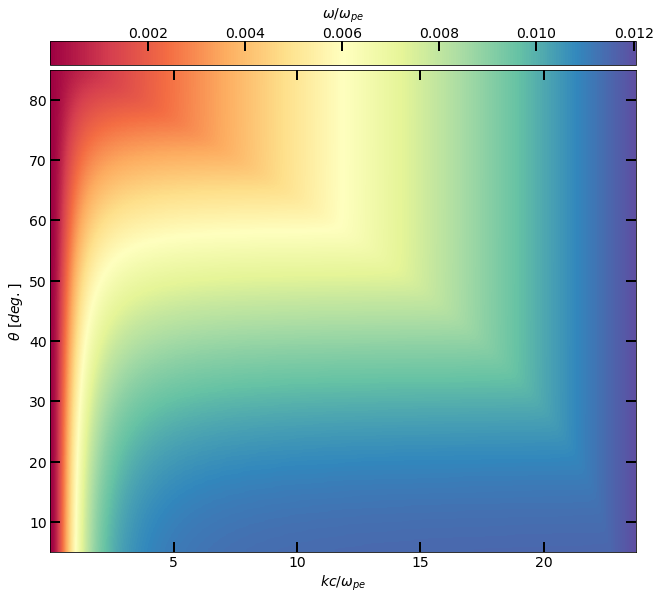

In [7]:
fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

# normalize data
k_prime = inputs["k"] * params["lpe"]
zdata = np.transpose(np.real(omegas["fast_mode"].value)) / params["wpe"].value

# plot
im = plt.imshow(
    zdata,
    aspect="auto",
    origin="lower",
    extent=[
        np.min(k_prime.value),
        np.max(k_prime.value),
        np.min(inputs["theta"].value),
        np.max(inputs["theta"].value),
    ],
    interpolation=None,
    cmap=plt.cm.Spectral,
)
ax = plt.gca()

# # adjust axes
ax.set_xscale("linear")
ax.set_xlabel(r"$kc/\omega_{pe}$", fontsize=fs)
ax.set_ylabel(r"$\theta$ [$deg.$]", fontsize=fs)
ax.tick_params(
    which="both",
    direction="in",
    width=2,
    labelsize=fs,
    right=True,
    top=True,
    length=10,
)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.07)
cbar = plt.colorbar(
    im,
    cax=cax,
    orientation="horizontal",
    ticks=None,
    fraction=0.05,
    pad=0.0,
)
cbar.ax.tick_params(
    axis="x",
    direction="in",
    width=2,
    length=10,
    top=True,
    bottom=False,
    labelsize=fs,
    pad=0.0,
    labeltop=True,
    labelbottom=False,
)
cbar.ax.xaxis.set_label_position("top")
cbar.set_label(r"$\omega/\omega_{pe}$", fontsize=fs, labelpad=8)

# Reproduce Figure 1 from Bellan 2012

[bellan2012]: https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2012JA017856


Figure 1 of [Bellan 2012][bellan2012] chooses parameters such that $\beta = 0.4$ and $\Lambda=0.4$.  Below we define parameters to approximate Bellan's assumptions.

In [8]:
# define input parameters
inputs = {
    "B": 400e-4 * u.T,
    "ion": Particle("He+"),
    "n_i": 6.358e19 * u.m**-3,
    "T_e": 20 * u.eV,
    "T_i": 10 * u.eV,
    "theta": np.linspace(0, 90) * u.deg,
    "k": (2 * np.pi * u.rad) / (0.56547 * u.m),
}

# a few useful plasma parameters
params = {
    "n_e": inputs["n_i"] * abs(inputs["ion"].charge_number),
    "cs": speeds.cs_(inputs["T_e"], inputs["T_i"], inputs["ion"]),
    "wci": wc_(inputs["B"], inputs["ion"]),
    "va": speeds.va_(inputs["B"], inputs["n_i"], ion=inputs["ion"]),
}
params["beta"] = (params["cs"] / params["va"]).value ** 2
params["wpe"] = wp_(params["n_e"], "e-")
params["Lambda"] = (inputs["k"] * params["va"] / params["wci"]).value ** 2

(params["beta"], params["Lambda"])

(0.4000832135717194, 0.4000017351804854)

In [9]:
# compute
omegas = two_fluid(**inputs)

In [10]:
# generate data for plots
plt_vals = {}
for mode, arr in omegas.items():
    norm = (np.absolute(arr) / (inputs["k"] * params["va"])).value ** 2
    plt_vals[mode] = {
        "x": norm * np.sin(inputs["theta"].to(u.rad).value),
        "y": norm * np.cos(inputs["theta"].to(u.rad).value),
    }

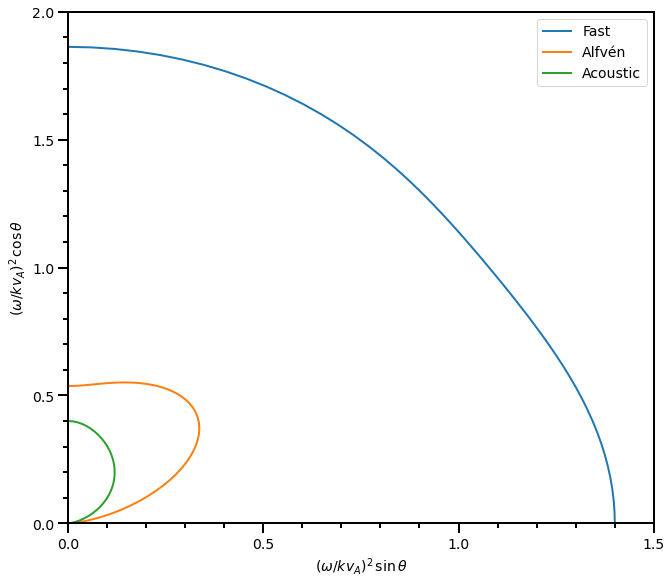

In [11]:
fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

# Fast mode
plt.plot(
    plt_vals["fast_mode"]["x"],
    plt_vals["fast_mode"]["y"],
    linewidth=2,
    label="Fast",
)
ax = plt.gca()

# adjust axes
ax.set_xlabel(r"$(\omega / k v_A)^2 \, \sin \theta$", fontsize=fs)
ax.set_ylabel(r"$(\omega / k v_A)^2 \, \cos \theta$", fontsize=fs)
ax.set_xlim(0.0, 1.5)
ax.set_ylim(0.0, 2.0)
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.minorticks_on()
ax.tick_params(which="both", labelsize=fs, width=2)
ax.tick_params(which="major", length=10)
ax.tick_params(which="minor", length=5)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))


# Alfven mode
plt.plot(
    plt_vals["alfven_mode"]["x"],
    plt_vals["alfven_mode"]["y"],
    linewidth=2,
    label="Alfvén",
)

# Acoustic mode
plt.plot(
    plt_vals["acoustic_mode"]["x"],
    plt_vals["acoustic_mode"]["y"],
    linewidth=2,
    label="Acoustic",
)

# annotations
plt.legend(fontsize=fs, loc="upper right")